# Build a Traffic Sign Recognition Classifier Deep Learning

`Note` : Code and Markdown cells can be executed using the Shift + Enter keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

*Package requirement : Tensorflow 2 with Keras, Anaconda + Python 3 + Numpy

Some improvements are taken :
- [x] Skip-connection
- [x] Use bias
- [x] Stride = 1 for first convolutional stage


## Load and Visualize the German Traffic Signs Dataset.

In [1]:
# Load pickled data
import pickle
import numpy

# TODO: Fill this in based on where you saved the training and testing data

training_file   = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file    = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels'] # training dataset
X_valid, y_valid = valid['features'], valid['labels'] # validation dataset used in training phase
X_test, y_test   = test['features'], test['labels']   # test dataset
n_classes        = len(numpy.unique(y_train))

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape    : {}".format(X_train[0].shape))
print()
print("Training Set   : {} samples".format(len(X_train)))
print("Validation Set : {} samples".format(len(X_valid)))
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes      : {}'.format(n_classes))
#X_train[0].shape
X_train.shape


Image Shape    : (32, 32, 3)

Training Set   : 34799 samples
Validation Set : 4410 samples
Test Set       : 12630 samples
n_classes      : 43


(34799, 32, 32, 3)

## Implementation of Resnet

In the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurélien Géron" `https://www.amazon.fr/dp/B07XGF2G87`, ResNet is explained in details. A significant particularity of ResNet is the application of a set of Convolutional Neural Networks with a skip connection, called Residual module :

<img src="figures/residual.png" alt="Drawing" style="width: 200px;"/>

>Source : Aurélien Géron, "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", page 471, Figure 14-17. 

ResNet's architecture :

<img src="figures/resnet_34_compact.png" alt="Drawing" style="width: 450px;"/>

>Source : Aurélien Géron, "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", page 468, Figure 14-14. 

We also can find an implementation of ResNet with Tensorflow and Keras by Dorian Lazar on Towardsdatascience :

>https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

In [2]:
### Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras import activations
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Nadam
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


In [3]:
def Residual(layer_in, filters, stride):
    # forward path
    layer  = Conv2D(filters, kernel_size=3, strides=stride, padding ='same', use_bias=False)(layer_in)
    layer  = BatchNormalization()(layer)
    layer  = Activation(activations.relu)(layer)
    layer  = Conv2D(filters, kernel_size=3, strides=1, padding ='same', use_bias=False)(layer)
    layer  = BatchNormalization()(layer)
    
    # skip path
    skip_layer = layer_in
    if stride > 1:
        skip_layer  = Conv2D(filters, kernel_size=1, strides=stride, padding ='same', use_bias=False)(skip_layer)
        skip_layer  = BatchNormalization()(skip_layer)
    
    return Activation(activations.relu)(layer + skip_layer)

In [4]:
#ResNet-34 model
def ResNet_34_Model(SHAPE):
    layer_in           = Input(shape=SHAPE, name='image_in')

    #1st stage Conv2D 7x7 + Normalization + MaxPool 3x3
    layer              = Conv2D(64, kernel_size=7, strides=1, padding='same', use_bias=False)(layer_in)
    layer              = BatchNormalization()(layer)
    layer              = Activation(activations.relu)(layer)
    layer              = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)
    layer1_conv1x1     = keras.layers.Conv2D(512, kernel_size=(16,16), strides=1, activation='relu', padding='valid')(layer)

    #2nd stage Deep network of Residuals
    #when depth (number of feature map) doubled, height and width of feature map are halved 
    #filter depth [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
    prev_filters       = 64
    for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3: 
        stride       = 1 if filters == prev_filters else 2
        layer        = Residual(layer, filters, stride)
        prev_filters = filters
        
    layer2_conv1x1     = keras.layers.Conv2D(512, kernel_size=(2,2), strides=1, activation='relu', padding='valid')(layer)

    #3rd stage GlobalAveragePool + Flatten + Fully Connected for classification
    layer              = GlobalAveragePooling2D()(layer)
    layer              = Flatten()(layer) # ?
    
    #Concatenate skip-connections
    layer3_flatten_1   = Flatten()(layer1_conv1x1)
    layer3_flatten_2   = Flatten()(layer2_conv1x1)    
    layer              = Concatenate()([layer, layer3_flatten_1, layer3_flatten_2])

    #Out layer wth softmax activation
    layer_out          = Dense(units=n_classes, activation='softmax')(layer)

    #ResNet-34 model
    ResNet_34          = keras.Model(layer_in, layer_out, name="ResNet_34_improved")
    return ResNet_34

Model: "ResNet_34_improved"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   3136        image_in[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
_________________________________________________________________________________

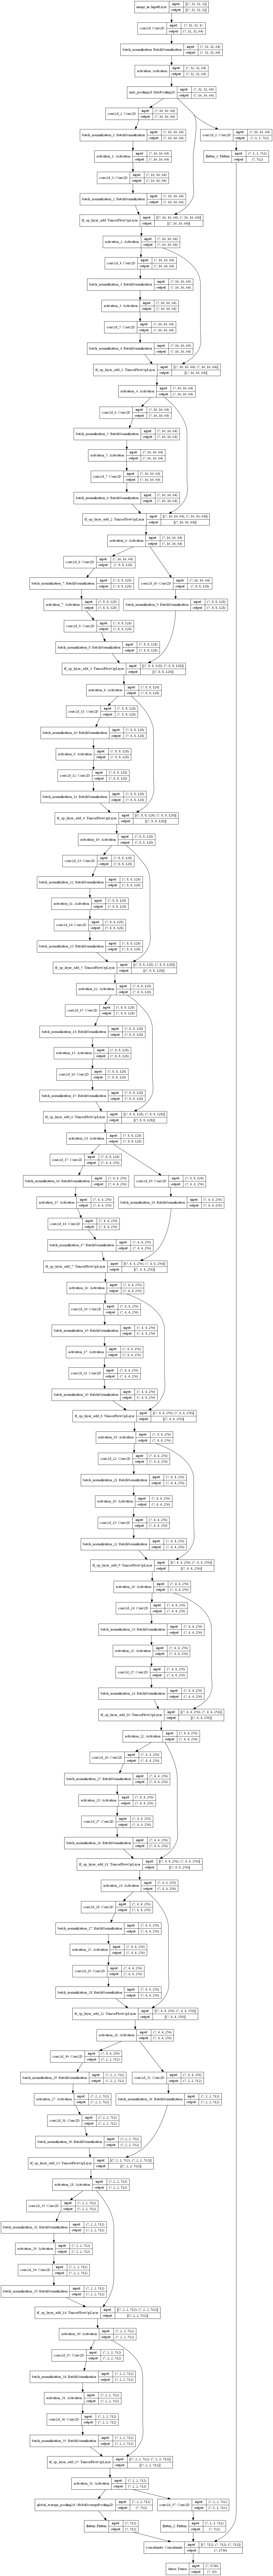

In [5]:
SHAPE     = (32,32,1)
ResNet_34 = ResNet_34_Model(SHAPE)

#Plot model architecture
ResNet_34.summary()
keras.utils.plot_model(ResNet_34, "figures/ResNet_34_improved.png", show_shapes=True)

### Input preprocessing

#### Color-Space
Pierre Sermanet and Yann LeCun used YUV color space with almost of processings on Y-channel (Y stands for brightness, U and V stand for Chrominance).  

#### Normalization
Each channel of an image is in uint8 scale (0-255), we will normalize each channel to 0-1.  
Generally, we normalize data to get them center around -1 and 1, to prevent numrical errors due to many steps of matrix operation. Imagine that we have 255x255x255x255xk operation, it could give a huge numerical error if we just have a small error in k.  

In [6]:
import cv2
def input_normalization(X_in):    
    X       = numpy.array([numpy.expand_dims(cv2.cvtColor(image_ij, cv2.COLOR_RGB2YUV)[:,:,0],2) for image_ij in X_in])
    X       = numpy.array([numpy.expand_dims(cv2.equalizeHist(numpy.uint8(image_ij)),2) for image_ij in X])
    X       = numpy.float32(X/255.0)
    # nomalize features
    X -= numpy.mean(X, axis=0)
    X /= (numpy.std(X, axis=0) + numpy.finfo('float32').eps)
    return X

In [7]:
# normalization of dataset
X_train_norm     = input_normalization(X_train)
X_valid_norm     = input_normalization(X_valid)

# one-hot matrix
y_train_onehot   = keras.utils.to_categorical(y_train, n_classes)
y_valid_onehot   = keras.utils.to_categorical(y_valid, n_classes)

In [8]:
print(X_train_norm.shape)
print('{0:.4g}'.format(numpy.max(X_train_norm)))
print('{0:.3g}'.format(numpy.min(X_train_norm)))

(34799, 32, 32, 1)
2.264
-2.78


### Training Pipeline
_Optimizer : we use Adam optimizer, better than SDG (Stochastic Gradient Descent)  
_Loss function : Cross Entropy by category  
_Metrics : accuracy  
*learning rate 0.001 work well with our network, it's better to try with small laerning rate in the begining.

### Real-time data augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            rotation_range=15.0,
            zoom_range=0.2,
            width_shift_range=0.1,
            height_shift_range=0.1,
            featurewise_center=False,
            featurewise_std_normalization=False,
            horizontal_flip=False)

# datagen.fit(X_train_norm)

### Train the Model


In [10]:
#learningrate decay for SDG
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
#learningrate decay for Adam/Nadam
# (learning_rate = rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
rate = 0.001

OPTIMIZER_param       = [Adam(learning_rate = rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07), SGD(learning_rate=lr_schedule), Nadam(learning_rate = rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)]
OPTIMIZER             = ['Adam', 'SGD', 'Nadam']

EPOCH           = [10, 10, 10]
BATCH_SIZE      = 32
STEPS_PER_EPOCH = int(len(X_train_norm)/BATCH_SIZE)
MODEL_NAME      = 'ResNet_34_improved.h5'

history         = {}

for i in range(len(OPTIMIZER)):
    print('Using optimizer : ' + OPTIMIZER[i] + ', Epoch size : ' + str(EPOCH[i]))
    
    datagen.fit(X_train_norm)
    
    ResNet_34.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                  optimizer=OPTIMIZER_param[i],
                  metrics=['accuracy'])
    
    train_history = ResNet_34.fit(
                    datagen.flow(X_train_norm, y_train_onehot, batch_size=BATCH_SIZE,shuffle=True),
                    validation_data=(X_valid_norm, y_valid_onehot),
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCH[i],
                    shuffle=True)
    
    # save history    
    if len(history) == 0:
        history = {key: [] for key in train_history.history}
    
    for key in history:
        history[key].extend(train_history.history[key])

ResNet_34.save(MODEL_NAME)

Using optimizer : Adam, Epoch size : 10
  ...
    to  
  ['...']
Train for 1087 steps, validate on 4410 samples
Epoch 1/10
1087/1087 [==============================] - 466s 429ms/step - loss: 1.9392 - accuracy: 0.5147 - val_loss: 0.7481 - val_accuracy: 0.7909
Epoch 2/10
1087/1087 [==============================] - 461s 424ms/step - loss: 0.3998 - accuracy: 0.8717 - val_loss: 0.6369 - val_accuracy: 0.8345
Epoch 3/10
1087/1087 [==============================] - 462s 425ms/step - loss: 0.2350 - accuracy: 0.9265 - val_loss: 0.2862 - val_accuracy: 0.9193
Epoch 4/10
1087/1087 [==============================] - 464s 427ms/step - loss: 0.1747 - accuracy: 0.9460 - val_loss: 0.2100 - val_accuracy: 0.9370
Epoch 5/10
1087/1087 [==============================] - 488s 449ms/step - loss: 0.1340 - accuracy: 0.9587 - val_loss: 0.0963 - val_accuracy: 0.9710
Epoch 6/10
1087/1087 [==============================] - 467s 430ms/step - loss: 0.1215 - accuracy: 0.9625 - val_loss: 0.2732 - val_accuracy: 0.9290


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
pickle.dump(history, open( "history_ResNet_34_improved.p", "wb" ))

In [14]:
with open("history_ResNet_34_improved.p", mode='rb') as f:
    history_ = pickle.load(f)


Plot of training error over 30 epochs:


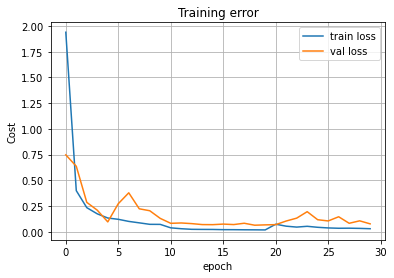

In [15]:
# Plot training error.
print('\nPlot of training error over 30 epochs:')
fig = plt.figure()
plt.title('Training error')
plt.ylabel('Cost')
plt.xlabel('epoch')
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.grid()
plt.show()
fig.savefig('figures/Training_loss_ResNet_34_improved.png', dpi=500)


Plot of training accuracy over 30 epochs:


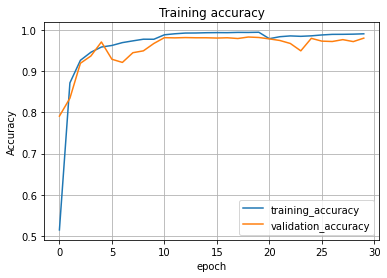

In [16]:
# Plot training error.
print('\nPlot of training accuracy over 30 epochs:')
fig = plt.figure()
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history_['accuracy'])
plt.plot(history_['val_accuracy'])
plt.legend(['training_accuracy', 'validation_accuracy'], loc='lower right')
plt.grid()
plt.show()
fig.savefig('figures/Training_accuracy_ResNet_34_improved.png', dpi=500)

### Prediction of test dataset with trained model
We will use the test dataset to test trained model's prediction of instances that it has never seen during training.

In [17]:
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes      : {}'.format(n_classes))
X_test.shape

Test Set       : 12630 samples
n_classes      : 43


(12630, 32, 32, 3)

In [18]:
#Normalize test dataset
X_test_norm   = input_normalization(X_test)
#One-hot matrix
y_test_onehot = keras.utils.to_categorical(y_test, n_classes)

In [19]:
#Load saved model
reconstructed = keras.models.load_model("ResNet_34_improved.h5")

#Evaluate and display the prediction
prediction_performance    = reconstructed.evaluate(X_test_norm,y_test_onehot)
dict(zip(reconstructed.metrics_names, prediction_performance))

12630/12630 [==============================] - 48s 4ms/sample - loss: 0.2003 - accuracy: 0.9576


{'loss': 0.2003042182922072, 'accuracy': 0.9576405}

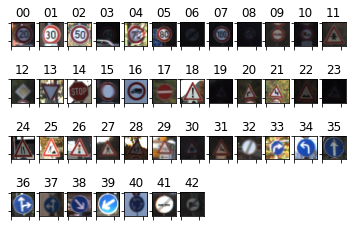

In [20]:
import matplotlib.pyplot as plot
%matplotlib inline
rows, cols   = 4, 12
fig, axes    = plot.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        X_test_of_class = X_test[y_test == idx]
        #X_train_0       = X_train_of_class[numpy.random.randint(len(X_train_of_class))]
        X_test_0        = X_test_of_class[0]
        ax.imshow(X_test_0)
        ax.set_title('{:02d}'.format(idx))
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.axis('off')
#
plot.draw()
fig.savefig('figures/' + 'test_representative' + '.jpg', dpi=700)

In [21]:
#### Prediction for all instances inside the test dataset
y_pred_proba   = reconstructed.predict(X_test_norm)
y_pred_class   = y_pred_proba.argmax(axis=-1)

### Showing prediction results for 10 first instances
for i, pred in enumerate(y_pred_class):
    if i <= 10:        
        print('Image {} - Target = {}, Predicted = {}'.format(i, y_test[i], pred))
    else:
        break

Image 0 - Target = 16, Predicted = 16
Image 1 - Target = 1, Predicted = 1
Image 2 - Target = 38, Predicted = 38
Image 3 - Target = 33, Predicted = 33
Image 4 - Target = 11, Predicted = 11
Image 5 - Target = 38, Predicted = 38
Image 6 - Target = 18, Predicted = 18
Image 7 - Target = 12, Predicted = 12
Image 8 - Target = 25, Predicted = 25
Image 9 - Target = 35, Predicted = 35
Image 10 - Target = 12, Predicted = 12


We will display a confusion matrix on test dataset to figure out our error-rate.  
`X_test_norm`    : test dataset  
`y_test`         : test dataset ground truth labels  
`y_pred_class`   : prediction labels on test dataset  

In [22]:
confusion_matrix = numpy.zeros([n_classes, n_classes])

#### confusion_matrix
`column`      : test dataset ground truth labels  
`row`         : prediction labels on test dataset  
`diagonal`    : incremented when prediction matches ground truth label  

In [23]:
for ij in range(len(X_test_norm)):
    if y_test[ij] == y_pred_class[ij]:
        confusion_matrix[y_test[ij],y_test[ij]] += 1
    else:
        confusion_matrix[y_pred_class[ij],y_test[ij]] -= 1

In [24]:
column_label = ['     L % d' % x for x in range(n_classes)]
row_label    = ['     P % d' % x for x in range(n_classes)]

In [25]:
# Plot classe representatives
import matplotlib.pyplot as plot
%matplotlib inline
rows, cols   = 1, 43
fig, axes    = plot.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        X_test_of_class = X_test[y_test == idx]
        X_test_0        = X_test_of_class[0]
        ax.imshow(X_test_0)
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
        # plot.tick_params(axis='both', which='both', bottom='off', top='off',
        # labelbottom='off', right='off', left='off', labelleft='off')
        ax.axis('off')
plot.draw()
fig.savefig('figures/' + 'label_groundtruth' + '.jpg', dpi=3500)

In [26]:
numpy.savetxt("confusion_matrix_ResNet34_improved.csv", confusion_matrix, delimiter=";")

#### Thank to confusion matrix, we could identify where to enhance  
-[x] training dataset  
-[x] real-time data augmentation  
-[x] preprocessing  

*Extract of confusion matrix of classification on test dataset &#8595;*  
<img src="figures/confusion_matrix_resnet34.png" alt="Drawing" style="width: 750px;"/>

### Prediction of new instances with trained model
We will use the test dataset to test trained model's prediction of instances that it has never seen during training.
I used 'softmax' activation in the last layer, so the output prediction is probabilities that input image is belong to a class.

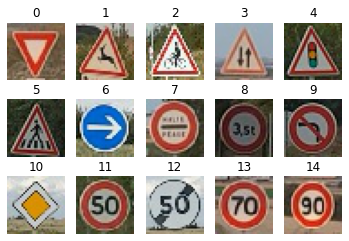

In [27]:
# load french traffic signs
import os
import cv2
import matplotlib.pyplot as plot
dir_frenchsign     = 'french_traffic-signs-data'
images_frenchsign  = [os.path.join(dir_frenchsign, f) for f in os.listdir(dir_frenchsign)]
images_frenchsign  = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in images_frenchsign]

# plot new test images
fig, axes          = plot.subplots(3, int(len(images_frenchsign)/3))
plot.title('French traffic signs')
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images_frenchsign[i])
    ax.set_title('{}'.format(i))
    plot.setp(ax.get_xticklabels(), visible=False)
    plot.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis('off')
plot.draw()
fig.savefig('figures/' + 'french_sign' + '.jpg', dpi=700)

*German traffic signs from INI dataset, in stardard form &#8595;*  
<img src="figures/german_sign.jpg" alt="Drawing" style="width: 600px;"/>

In [28]:
# manually label for these new images
y_frenchsign       = [13, 31, 29, 24, 26, 27, 33, 17, 15, 34, 12, 2, 2, 4, 2]
n_classes          = 43

# when a sign doesn't present in our training dataset, we'll try to find a enough 'similar' sign to label it.

# image 2 : class 29 differed 
# image 3 : class 24, double-sens not existed 
# image 5 : class 27 differed
# image 6 : class 33 not existed 
# image 7 : class 17, halte-péage not existed 
# image 8 : class 15, 3.5t limit not existed 
# image 9 : class 15, turn-left inhibition not existed
# image 12 : class 2, ending of 50kmh speed-limit not existed
# image 14 : class 2, 90kmh speed-limit not existed

#### it's really intersting that somes common french traffic signs are not present in INI German traffic signs dataset or differed
Whatever our input - evenif it's not present in the training dataset, by using softmax activation our classififer can not say that 'this is a new traffic sign that it doesn't recognize' (sum of probability across all classes is 1), it's just try to find class that probably suit for the input.

In [29]:
#Normalize the dataset
X_frenchsign_norm        = input_normalization(images_frenchsign)
#One-hot matrix
y_frenchsign_onehot      = keras.utils.to_categorical(y_frenchsign, n_classes)

#Load saved model
reconstructed            = keras.models.load_model("ResNet_34_improved.h5")

#Evaluate and display the prediction performance
prediction_performance   = reconstructed.evaluate(X_frenchsign_norm, y_frenchsign_onehot)
dict(zip(reconstructed.metrics_names, prediction_performance))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run LogicalNot: Dst tensor is not initialized. [Op:LogicalNot]

In [ ]:
#### Prediction for all instances inside the test dataset
y_pred_proba             = reconstructed.predict(X_frenchsign_norm)
y_pred_class             = y_pred_proba.argmax(axis=-1)

### Showing prediction results
for i, pred in enumerate(y_pred_class):   
    print('Image {} - Target = {}, Predicted = {}'.format(i, y_frenchsign[i], pred))

*French traffic signs to classsify &#8595;*  
<img src="figures/french_sign_compare_german_INI.jpg" alt="Drawing" style="width: 750px;"/>

In [ ]:
#### plot softmax probs along with traffic sign examples
n_img        = X_frenchsign_norm.shape[0]
fig, axarray = plot.subplots(n_img, 2)
plot.suptitle('Visualization of softmax probabilities', fontweight='bold')
for r in range(0, n_img):
    axarray[r, 0].imshow(numpy.squeeze(images_frenchsign[r]))
    axarray[r, 0].set_xticks([]), axarray[r, 0].set_yticks([])
    plot.setp(axarray[r, 0].get_xticklabels(), visible=False)
    plot.setp(axarray[r, 0].get_yticklabels(), visible=False)
    axarray[r, 1].bar(numpy.arange(n_classes), y_pred_proba[r])
    axarray[r, 1].set_ylim([0, 1])
    plot.setp(axarray[r, 1].get_yticklabels(), visible=False)
plot.draw()
fig.savefig('figures/' + 'french_sign_softmax_visuali_ResNet_34_improved' + '.jpg', dpi=700)
    
K = 3
#### print top K predictions of the model for each example, along with confidence (softmax score)    
for i in range(len(images_frenchsign)):
    print('Top {} model predictions for image {} (Target is {:02d})'.format(K, i, y_frenchsign[i]))
    top_3_idx    = numpy.argsort(y_pred_proba[i])[-3:]
    top_3_values = y_pred_proba[i][top_3_idx]    
    for k in range(K):
        print('   Prediction = {:02d} with probability {:.4f}'.format(top_3_idx[k], top_3_values[k]))

*Visualization of softmax probabilities &#8595;*  
<img src="figures/french_sign_softmax_visuali_ResNet_34_improved.jpg" alt="Drawing" style="width: 750px;"/>

## Visualization of layers

In [1]:
### Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
import matplotlib.pyplot as plot

print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


In [2]:
# Load pickled data
import pickle
import numpy

training_file    = 'traffic-signs-data/train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels'] # training dataset
n_classes        = len(numpy.unique(y_train))

In [3]:
import cv2
def input_normalization(X_in):    
    X       = numpy.array([numpy.expand_dims(cv2.cvtColor(image_ij, cv2.COLOR_RGB2YUV)[:,:,0],2) for image_ij in X_in])
    X       = numpy.array([numpy.expand_dims(cv2.equalizeHist(numpy.uint8(image_ij)),2) for image_ij in X])
    X       = numpy.float32(X/255.0)
    # nomalize features
    X -= numpy.mean(X, axis=0)
    X /= (numpy.std(X, axis=0) + numpy.finfo('float32').eps)
    return X

# normalization of dataset
X_train_norm     = input_normalization(X_train)

# one-hot matrix
y_train_onehot   = keras.utils.to_categorical(y_train, n_classes)

In [5]:
#Load saved model
reconstructed            = keras.models.load_model("ResNet_34_improved.h5")

#Build model for layer display
layers_output            = [layer.output for layer in reconstructed.layers]
outputs_model            = Model(inputs=reconstructed.input, outputs=layers_output)
outputs_history          = outputs_model.predict(X_train_norm[900].reshape(1,32,32,1))

#### Display analized input

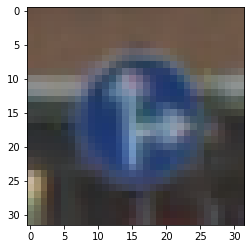

In [18]:
plot.imshow(X_train[900])

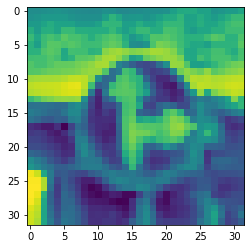

In [6]:
plot.imshow(X_train_norm[900][:,:,0]);

In [7]:
def display_layer(outputs_history, col_size, row_size, layer_index): 
    activation       = outputs_history[layer_index]
    activation_index = 0
    fig, ax          = plot.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].axis('off')
            if activation_index < activation.shape[3]:
                ax[row][col].imshow(activation[0, :, :, activation_index])   # , cmap='gray'             
                activation_index += 1

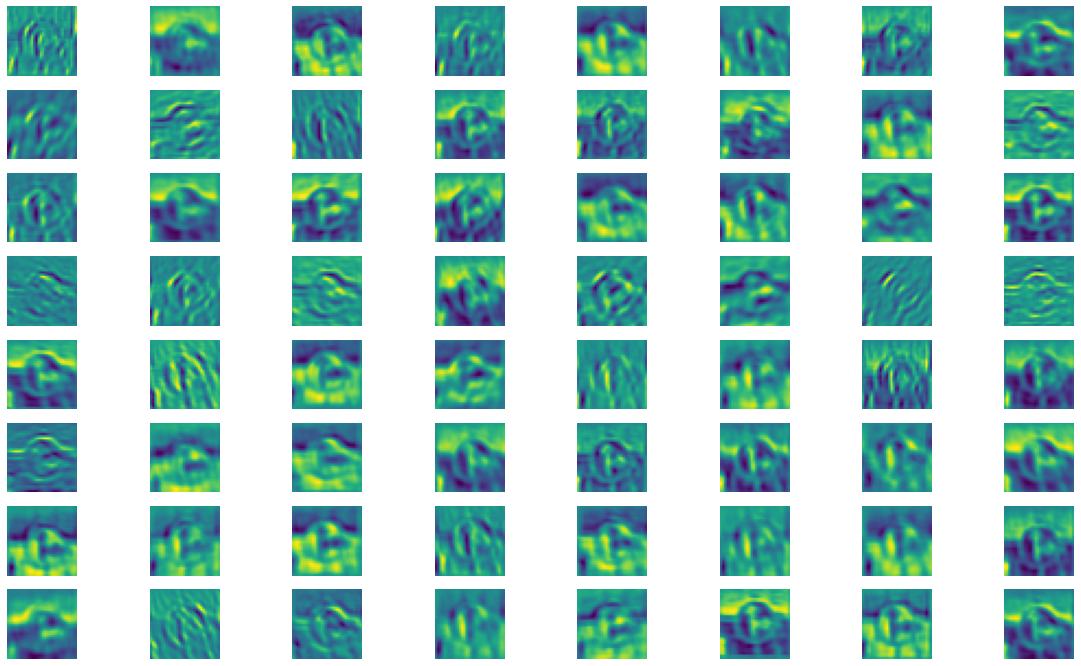

In [8]:
display_layer(outputs_history, 8, 8, 1)

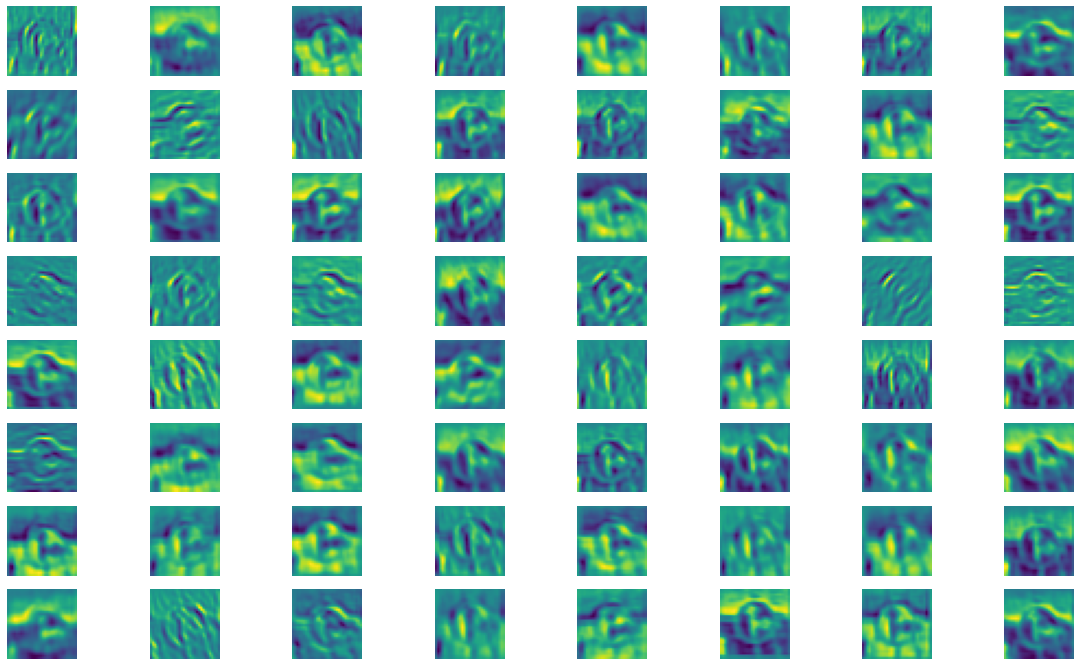

In [9]:
display_layer(outputs_history, 8, 8, 2)

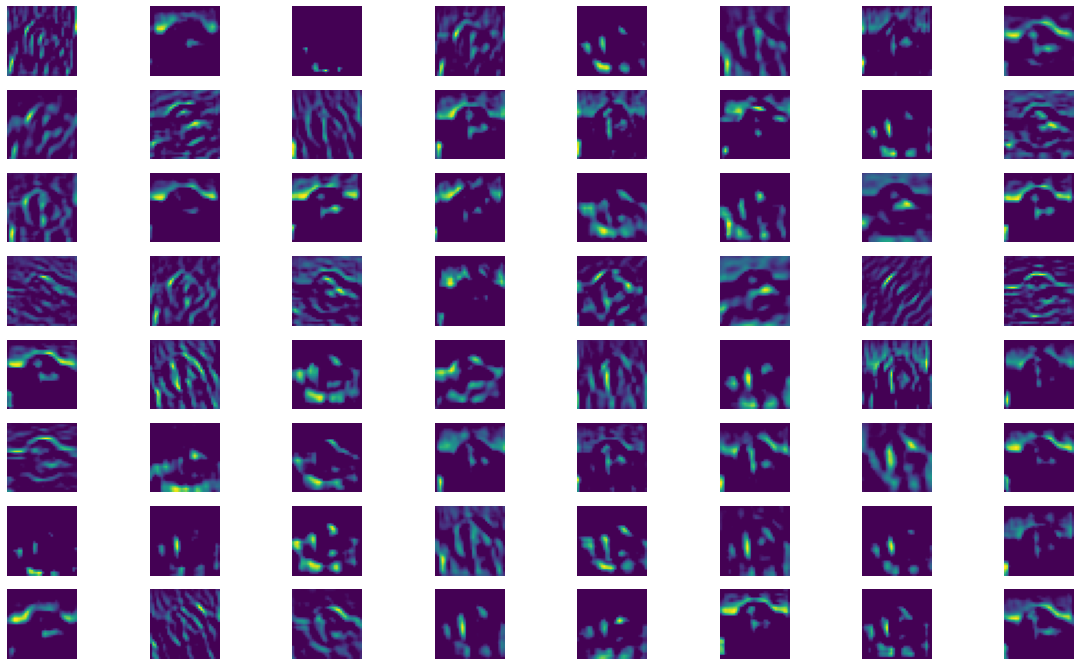

In [17]:
display_layer(outputs_history, 8, 8, 3)

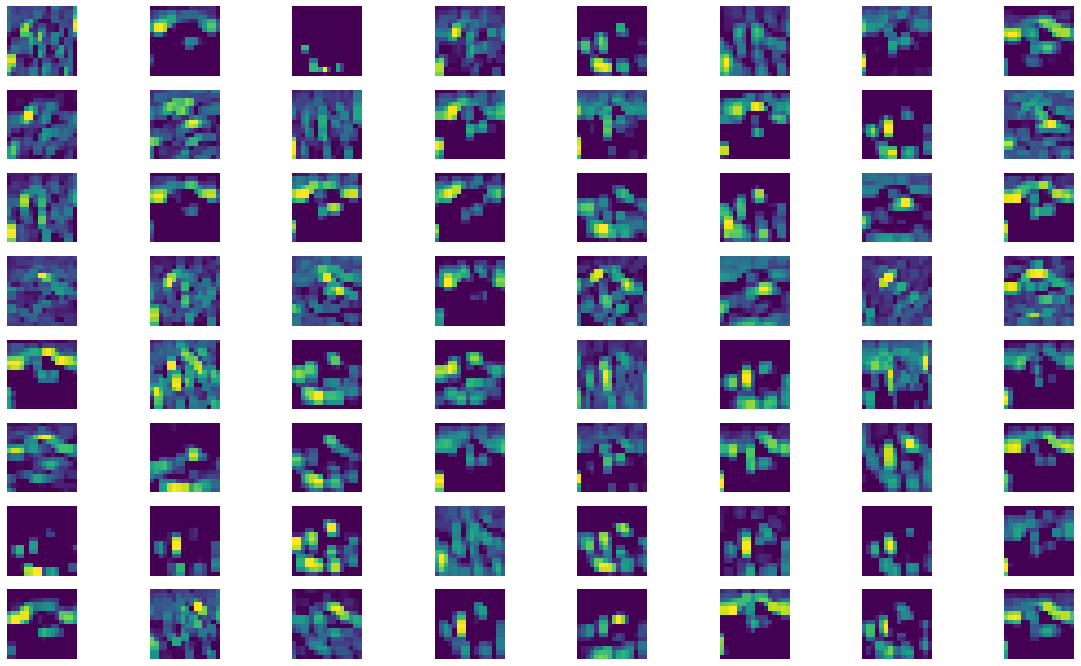

In [14]:
display_layer(outputs_history, 8, 8, 4)

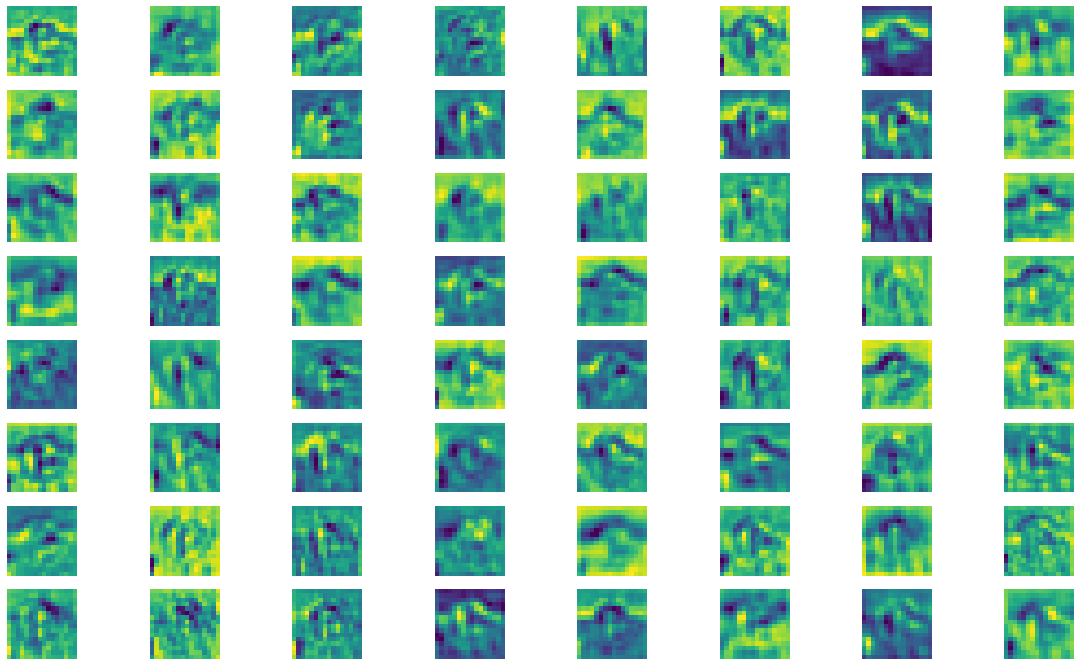

In [15]:
display_layer(outputs_history, 8, 8, 5)

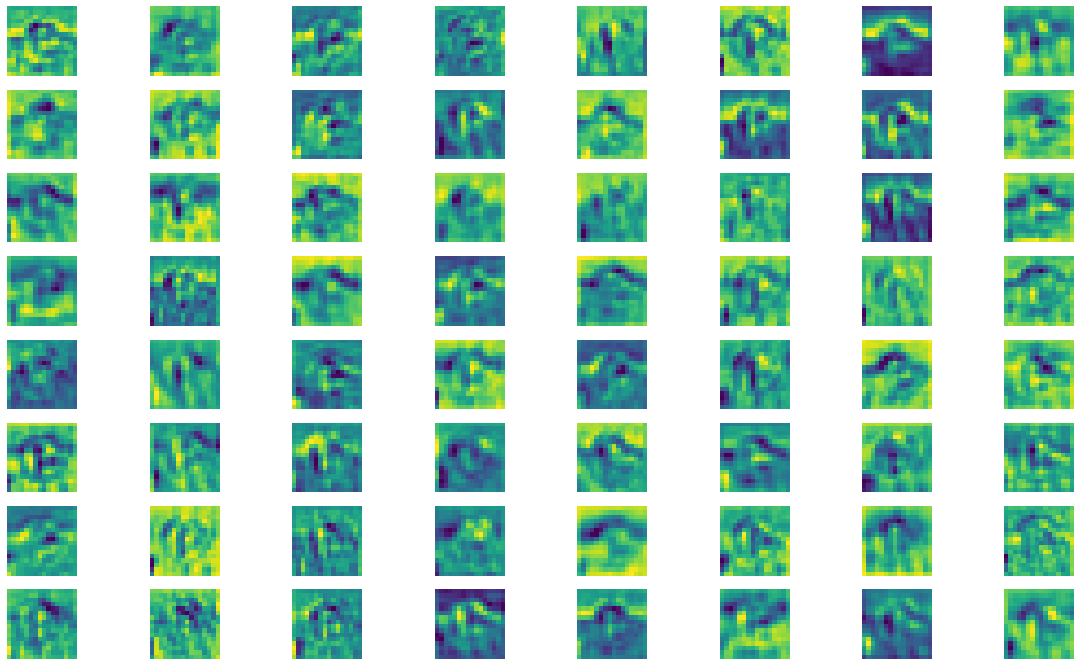

In [16]:
display_layer(outputs_history, 8, 8, 6)